# <font color='blue'><font size ='9'>  Instance Segmentation and Classification

In this module will learn the basic concepts of machine learning instance segmentation and classification.

# Preparations

## Switch to a T4 GPU runtime environment
**Very important step! Do this now!** Colab will reset the notebook after this step and erase any uploaded files or results you have produced.

At top of Google Colab, click:
1. Runtime
2. Change runtime type
3. Select T4 GPU
4. Click Save at the bottom right

## Download zip file
1. Download the the file img_class.zip from the Google Drive link:
2. Colab has a toolbar on the left side of the screen. Click on the folder icon to open the files panel.
3. Click on the upload icon (piece of paper with arrow pointing up on it).
4. Select the location of img_class.zip on your computer and upload it.
5. This upload may take up to 20 minutes to complete.

## Begin installing required libraries

In [ ]:
# Install the ultralytics package using pip
!pip install ultralytics

# Import YOLO and other dependent libraries
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

# Install the SAHI package using pip and import predict library
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install sahi
from sahi.predict import predict

# <font color='blue'> <font size ='6'> 1. Evaluation Metrics for Classification

# Section 1 Topics:
* The confusion matrix
* Accuracy
* Precision
* Recall
* F1 score
* Precision-recall curve
* PR AUC score | average precision
* Mean average precision

https://neptune.ai/blog/evaluation-metrics-binary-classification

## 1.1 The confusion matrix

A confusion matrix is a way of presenting true positive (tp), true negative (tn), false positive (fp) and false negative (fn) predictions.
Those categories are presented in the form of a matrix where the Y-axis shows the true classes while the X-axis shows the predicted classes.

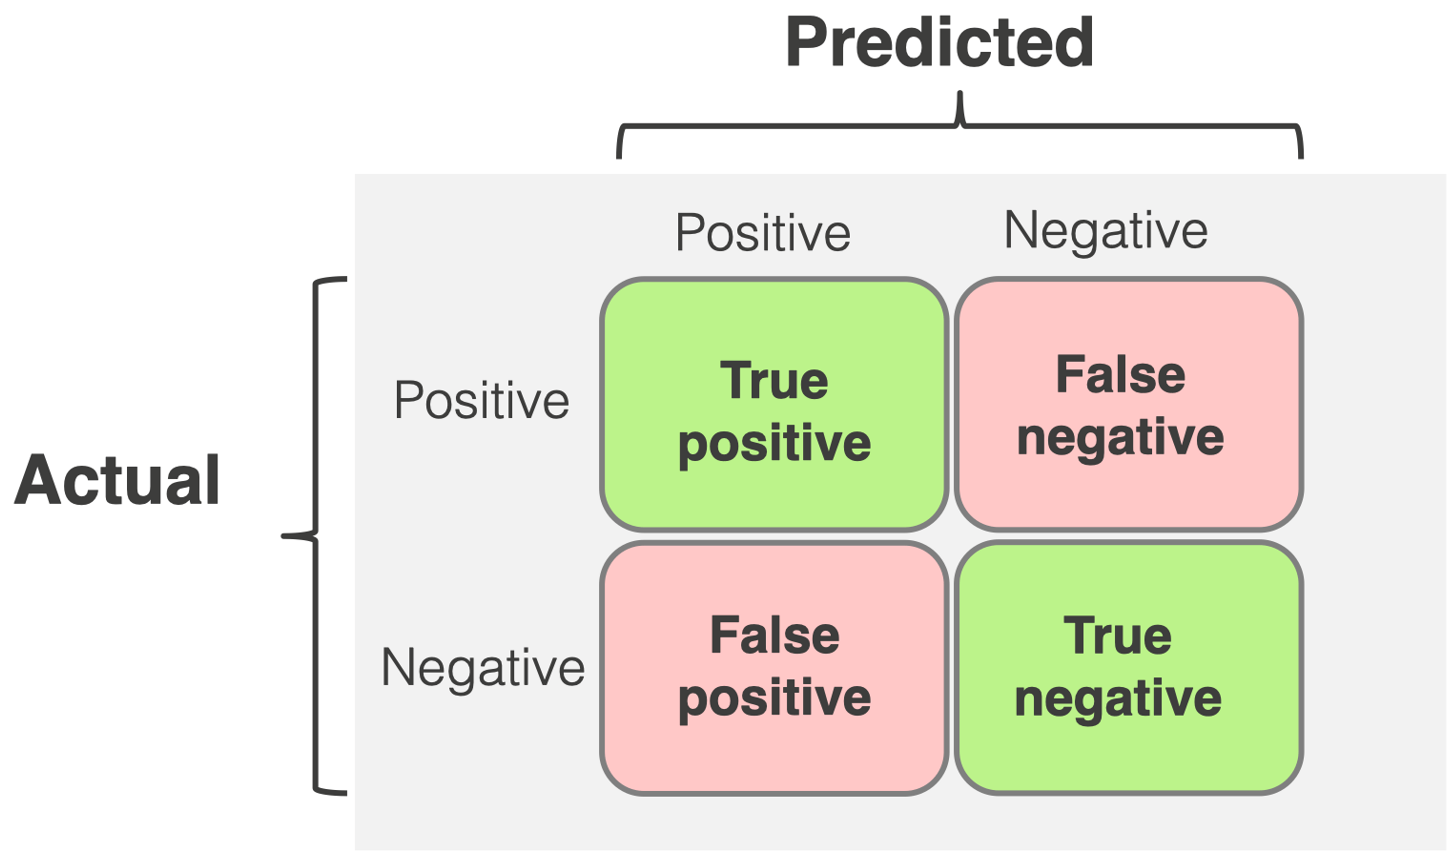

Later on, we will look at a model that identifies xylem vessels of plants with tyloses, which are produced by plants as a response to vascular pathogens. In our example, let's say there are 1,000,010 vessels, and 10 of those vessels have tyloses. When we run our model, it correctly found 5 (TP), it did not find 5 (FN), it found 5 that did not exist (FP) and it recognized that 999,995 vessels did not have any.

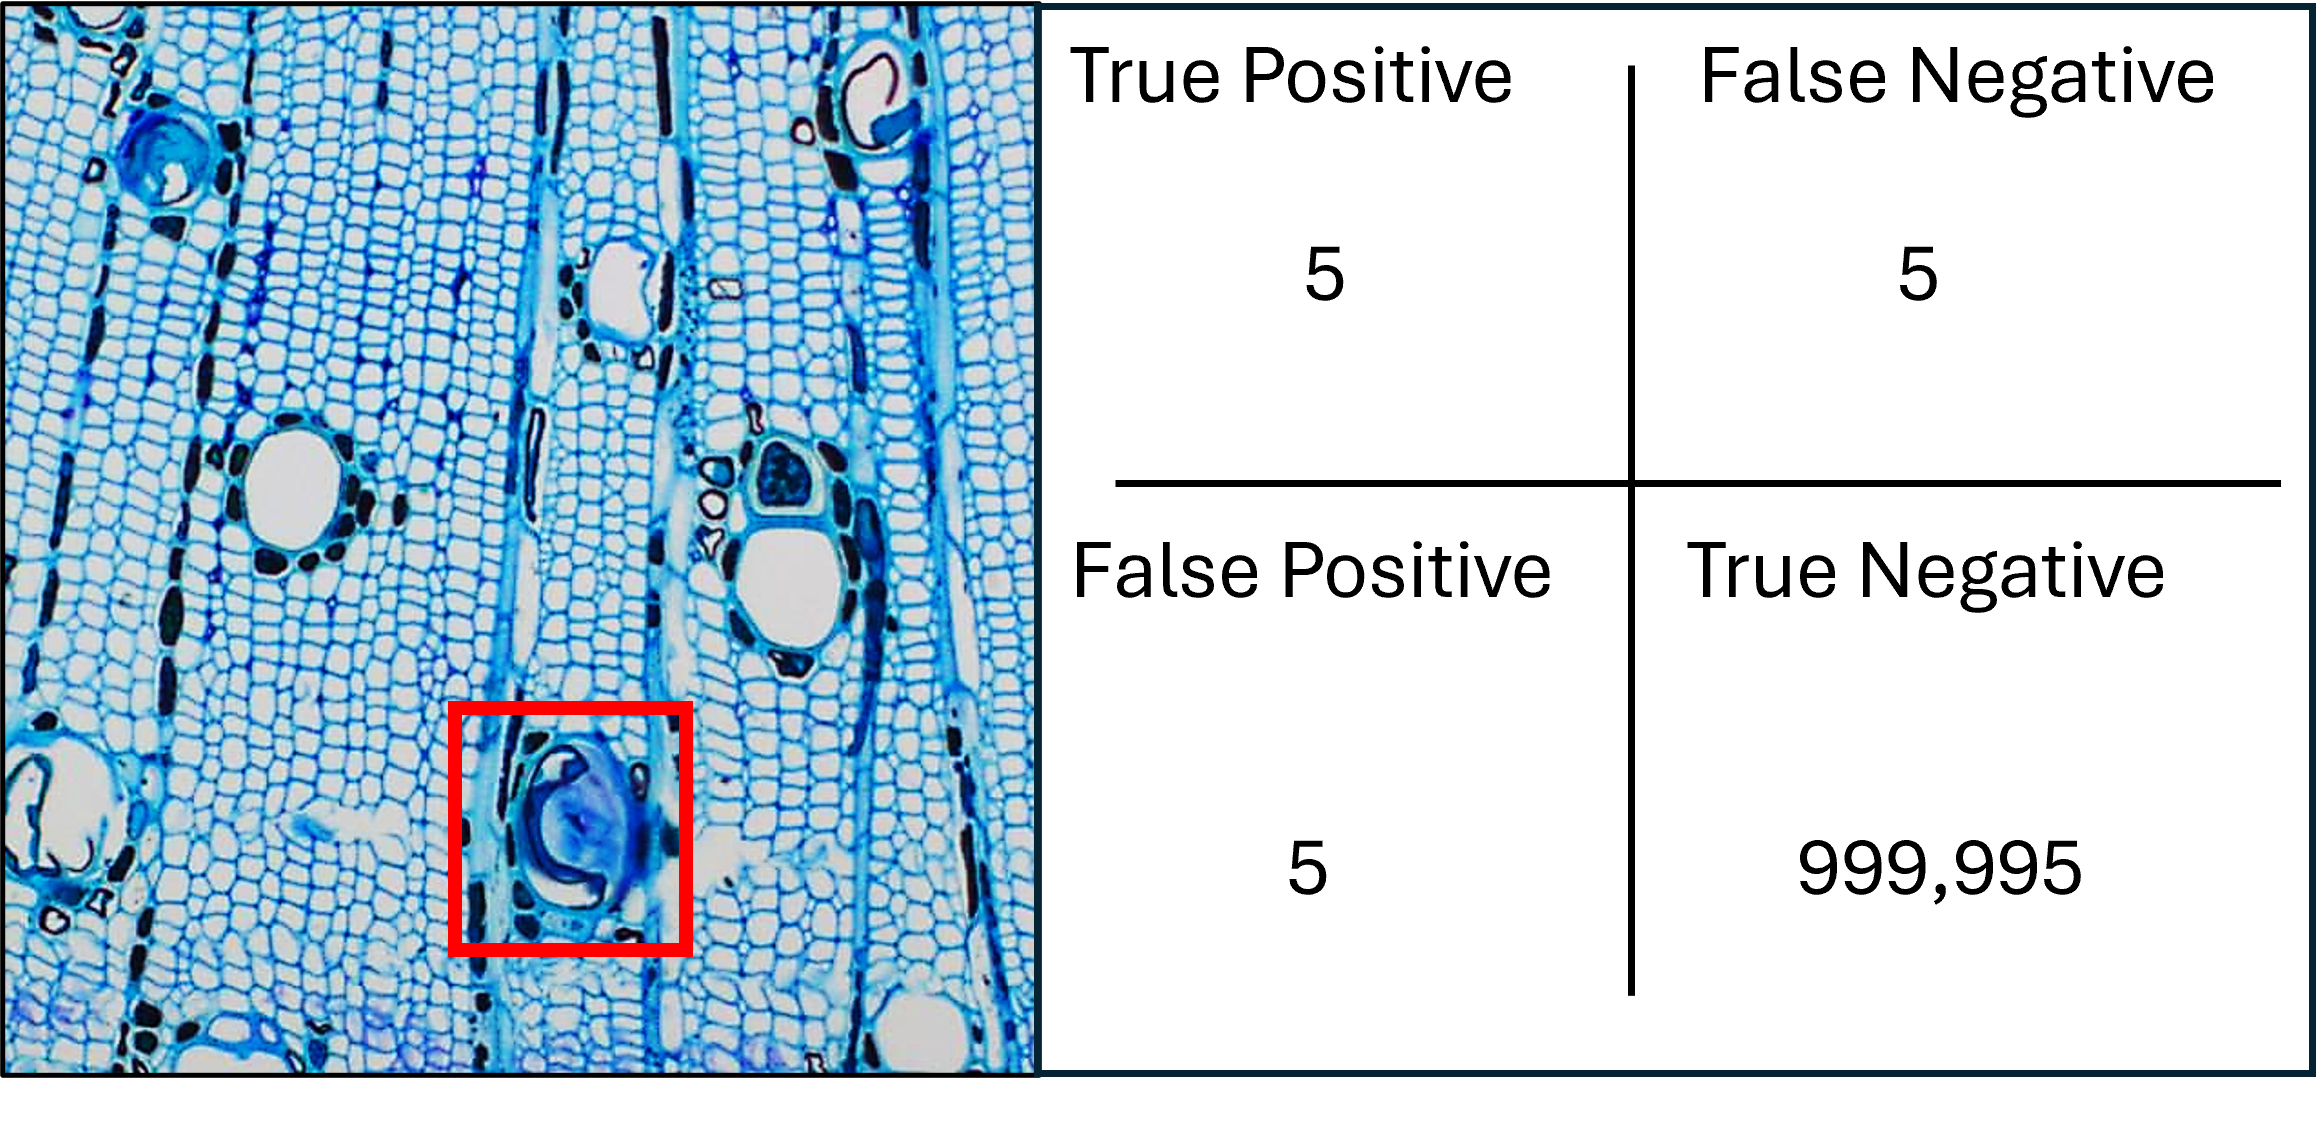


## 1.2 Accuracy

It measures how many observations, both positive and negative, were correctly classified.

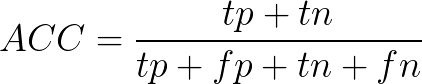

You shouldn’t use accuracy on **imbalanced** problems. Then, it is easy to get a high accuracy score by simply classifying all observations as the **majority** class.

In our example, there are 10 tyloses and the model only predicted 5 correctly and 5 incorrectly. However, the model accuracy would be (5 + 999,995) / (5 + 5 + 999,9995 + 5) = 99%!

## 1.3 Precision | positive predictive value

It measures how many observations predicted as positive are in fact positive. Or, is the model finding tyloses that are not actually there?

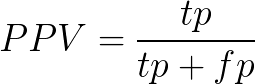

In our example, the precision of predicting tyloses would be 5 / (5 + 5) = 50%

## 1.4 Recall | true positive rate | sensitivity

It measures if you found all the instances of true positives. In our example, it asks whether we are missing tyloses present on the stem section.

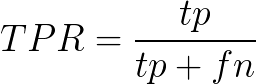

In our example: 5 / (5 + 5) = 50%

## 1.5 F1 score

F1 score is the harmonic mean between precision and recall, a special case of F beta score (**beta = 1**).

The F beta score combines precision and recall into one metric. The higher the score the better our model is. It can be calculated in the following way:

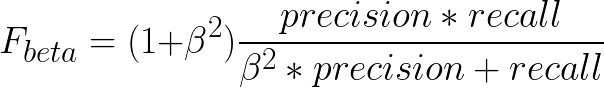

When choosing beta in the F-beta score, the **higher beta** means the **more you care about recall** over precision. For example, with F1 score we care equally about recall and precision; with F2 score, recall is twice as important to us.

## 1.6 Precision-recall curve

It is a curve that combines precision (PPV) and recall (TPR) in a single visualization. For every threshold, you calculate PPV and TPR and plot it. The higher on y-axis your curve is the better your model performance.

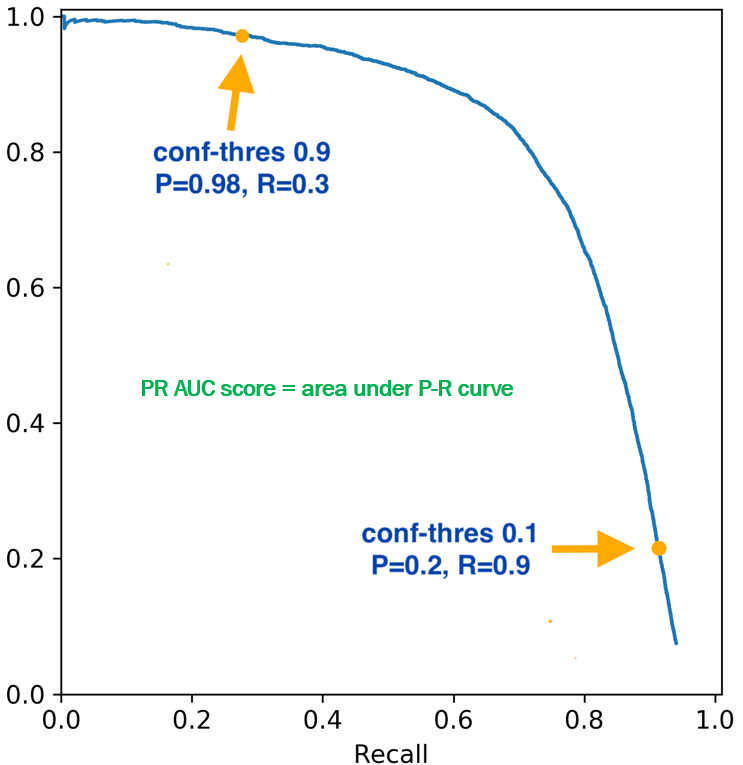


You can use this plot to make an educated decision when it comes to the classic precision/recall dilemma. Obviously, the higher the recall the lower the precision. Knowing **at which recall your precision starts to fall fast** can help you choose the threshold and deliver a better model.

## 1.7 PR AUC score | average precision
 In order to get one number that tells us how good our curve is, we can calculate the Area Under the PR Curve, or PR AUC score. The more top-right your curve is the higher the area and hence higher PR AUC score.

You can also think about PR AUC as the average of precision scores calculated for each recall threshold [0, 1]. You can also adjust this definition to suit your project needs by choosing/clipping recall thresholds if needed.


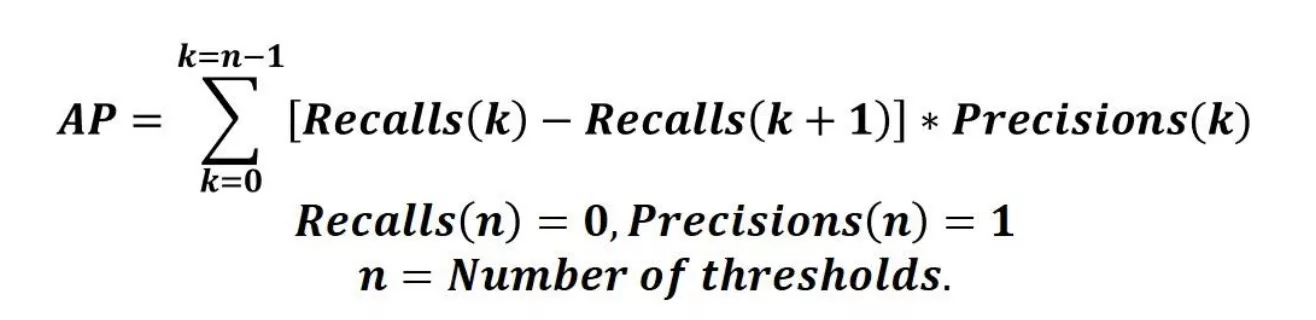

## 1.8 Mean average precision (mAP)

The mAP is calculated by finding Average Precision (AP) for each class and then average over a number of classes.

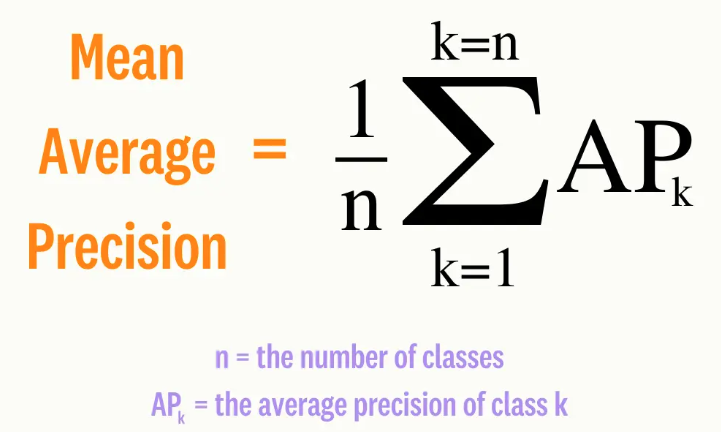

# <font color='blue'><font size ='6'> 2. Instance Segmentation and Classification Example: Counting Vessels and Vessels with Tyloses


## 

## The problem: Counting vessels and vessels with tyloses is time consuming
Counting the number of vessels and tyloses is time consuming because there are thousands of vessels of on each transverse stem section.

## The solution: instance segmentation
Select a pre-trained image-segmentation model to train on custom images. The target variables will be treated as two classes during the instance segmentation.

## Section 2 objective:
* Train a custom YOLO v8 model using your own data

## 2.1 Data preparation

The data used in this notebook is the **courtesy of**: **Joshua Konkol, Jeffrey Rollins**

If you already have annotations in COCO format JSON file, for example by annotating using makesense (https://www.makesense.ai/) then the annotations can be imported to Roboflow for conversion to YOLO format.

Otherwise, if you are starting from scratch, just annotate datasets on Roboflow. (https://roboflow.com/). You just need to upload your images along with the JSON file and Roboflow will convert them to any other format, in our case YOLO v8.

For information about YOLO models:

https://docs.ultralytics.com/models/yolov8/#key-features

In [ ]:
# Unzip file
import requests
from zipfile import ZipFile
with ZipFile('/content/img_class.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/img_class')

## 2.2 Import a model and populate it with pre-trained weights.

Here, we are importing an instance segmentation model with weights.
For a list of pre-trained models, checkout: https://docs.ultralytics.com/models/yolov8/#key-features

In [ ]:
# Resume training from model developed previously, or in this case a new model from YOLOv8.
model = YOLO('/content/img_class/yolov8n.pt')  # Transfer the weights from a pretrained model

# Alternatively, in case GPUs don't work, a pretrained model can be used in the code commented out below.
# model = YOLO('/content/img_class/best.pt')

## 2.3 Train the model

In [ ]:
#Define a project --> Destination directory for all results
project = "/content/img_class/results_v8"

#Define subdirectory for this specific training
name = "10_epochs-" #note that if you run the training again, it creates a directory: 10_epochs-2; epochs are just iterations

# Train the model
results = model.train(data='/content/img_class/data.yaml',
                      project=project,
                      name=name,
                      epochs=6, # Epoch is an iteration
                      agnostic_nms=True,
                      patience=0, # Number of epochs with no model improvements before training automatically terminates. High numbers can cause overfitting.
                      batch=8, # Batch = number of images used for training per epoch. High numbers, or using your entire training dataset each epoch, will lead to overfitting.
                      imgsz=640)


## 2.4 Check the training results

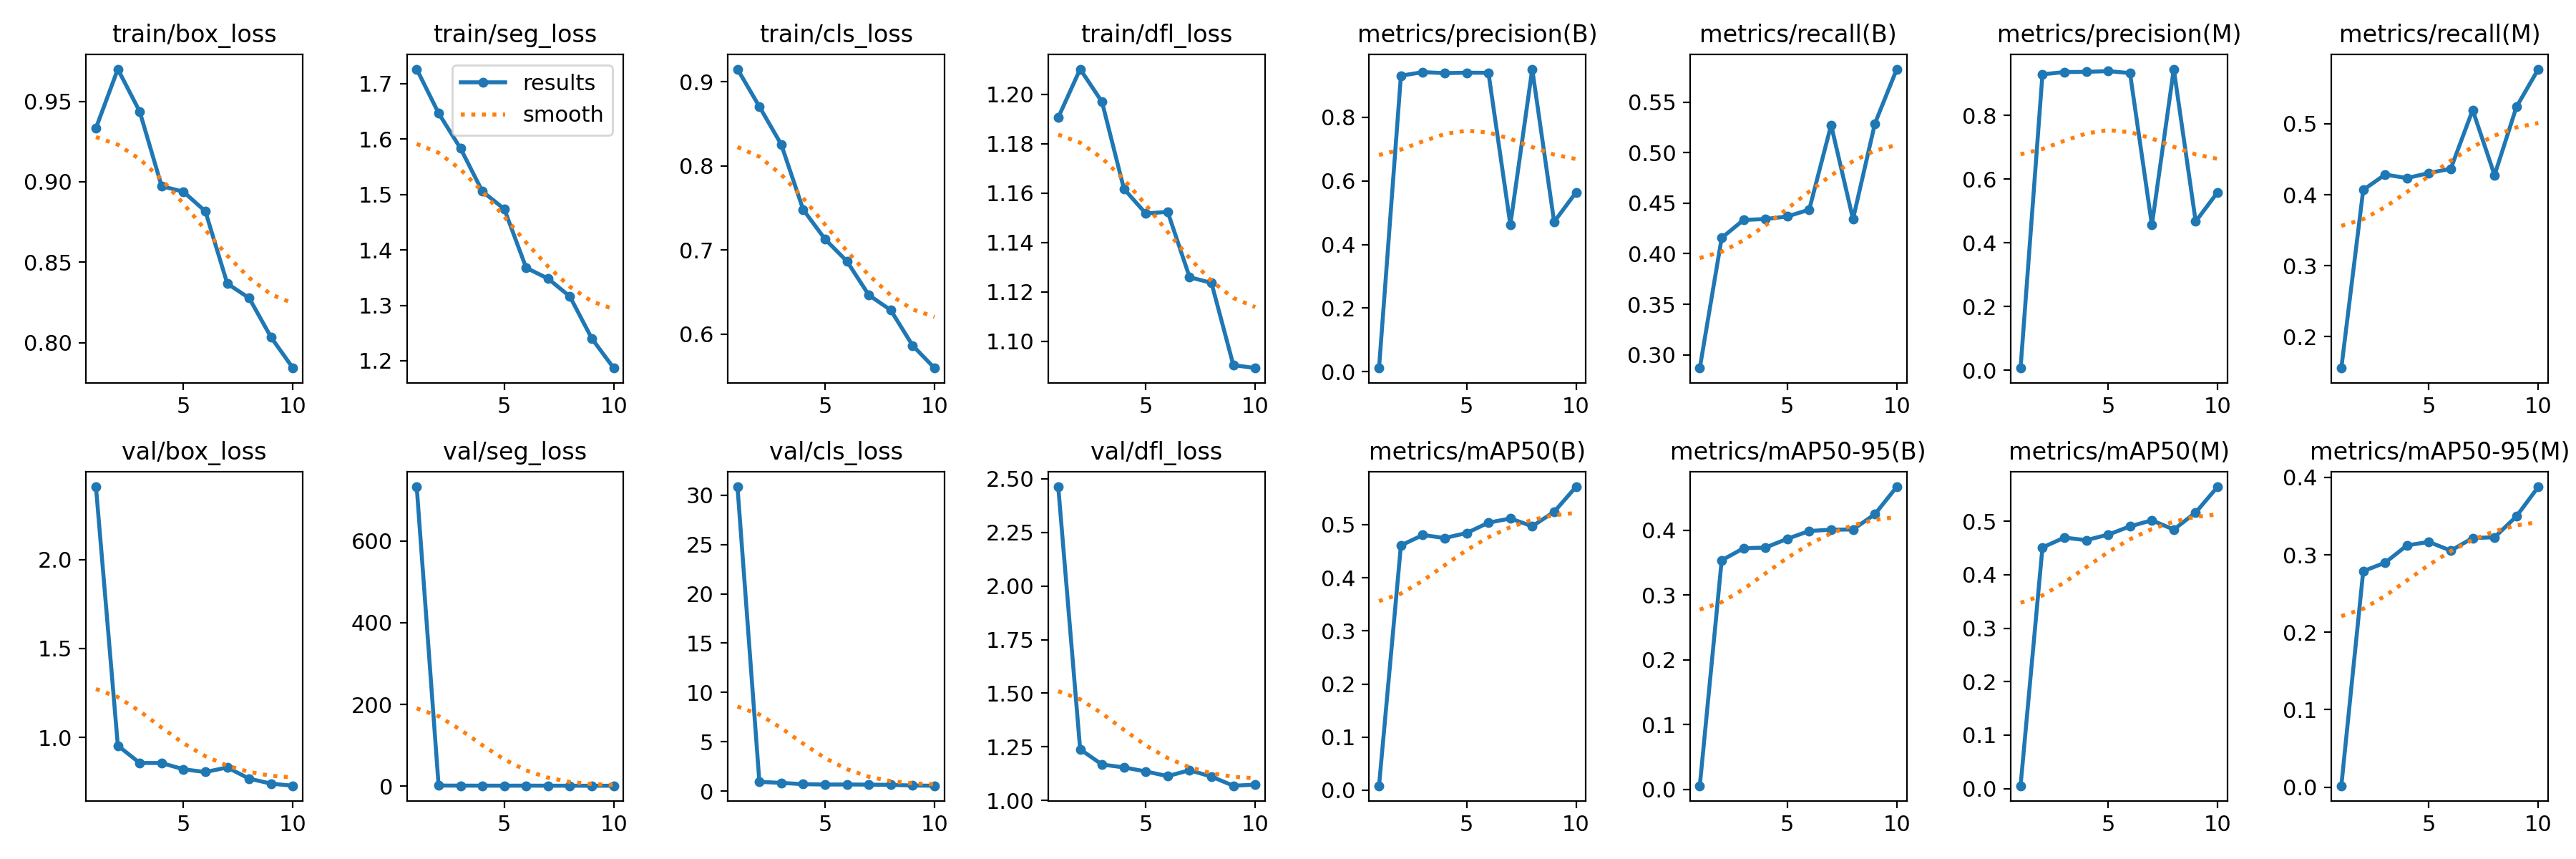

In [ ]:
from IPython.display import Image
Image("/content/img_class/results_v8/10_epochs-/results.png")

In [ ]:
Image(filename='/content/img_class/results_v8/10_epochs-/val_batch2_labels.jpg', width=900)

## 2.5 Run inference  

### 2.5.1 Update the model using the training data

In [ ]:
# Replace old model with the new one named "my_new_model" by selecting the new training weights we produced in the file "best.pt".
my_new_model = YOLO('/content/img_class/results_v8/10_epochs-/weights/best.pt')
# Check mextrics of the model.
metrics = my_new_model.val()

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8x-seg summary (fused): 295 layers, 71722582 parameters, 0 gradients, 343.7 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 12.4MB/s]
val: Scanning /content/drive/MyDrive/Data/2-3images_640x640.v2i.yolov8/valid/labels.cache... 362 images, 0 backgrounds, 0 corrupt: 100%|██████████| 362/362 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [44:24<00:00, 115.83s/it]


                   all        362       2175      0.564      0.583      0.571      0.466      0.559      0.577      0.564      0.384
                tylose        362         82      0.312       0.22      0.195      0.147      0.312       0.22      0.195      0.116
                vessel        362       2093      0.815      0.946      0.947      0.786      0.805      0.934      0.933      0.652
Speed: 11.6ms preprocess, 7290.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/val


### 2.5.2 Predicting classes using our model
Now that we have trained our model, we can begin using the new model to analyze images for us.

In [ ]:
# Small image predictions
new_image = '/content/img_class/valid/images/LauC_-2_3_ch00_6144_13824_6784_14464_png.rf.5448c1eb01390e55e2590d726aa97a1d.jpg' # Assign variable with the name of an image for prediction
new_results = my_new_model.predict(new_image, conf=0.2)  # Predict vessels and tyloses in the image
new_result_array = new_results[0].plot() # Plot the results 
plt.figure(figsize=(12, 12)) # Set figure size
plt.imshow(new_result_array) # Show results on the image


image 1/1 /content/drive/MyDrive/Data/2-3images_640x640.v2i.yolov8/valid/images/LauA_-2_2_10240_10752_10880_11392_png.rf.79698d4b7562a8d5e745b44289742020.jpg: 640x640 6 vessels, 6171.1ms
Speed: 3.5ms preprocess, 6171.1ms inference, 38.4ms postprocess per image at shape (1, 3, 640, 640)


### 2.5.3 Try running predictions on a large image

In [ ]:
# Large image predictions
large_image = '/content/img_class/large_img.png'
new_results = my_new_model.predict(large_image, conf=0.5)  #Adjust conf threshold

new_result_array = new_results[0].plot()
plt.figure(figsize=(12, 12))
plt.imshow(new_result_array)

#### **No predictions were made!**
Image segmentation can fail if the size of an image is too large. You can resolve this problem by slicing large images up into pieces.

## 2.6 Slicing large images with SAHI
The SAHI package was designed to split up large images so they can be analyzed.

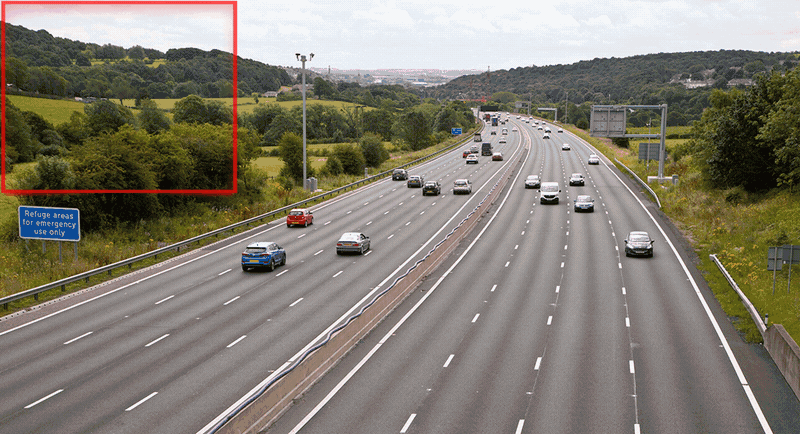

https://github.com/obss/sahi

### 2.6.1 Configure variables to use with SAHI

In [ ]:
# Set model path, model_config path and image folder
model_path="/content/img_class/results_v8/10_epochs-/weights/best.pt" # Path to our model
model_config_path= "/content/img_class/data_sahi.yaml" # The model configuration path, this is needed to use options for SAHI. When making your own, be sure to set agnostic_nms=True in the .yaml file
images_dir = "/content/img_class/large_img.png" # The image directory, or in our case, just one large .png file

### 2.6.2 Perform predictions on a large image

In [ ]:
# Run prediction model on the large file by slicing it up with SAHI
predict(
    model_type="yolov8",
    model_path=model_path,
    model_config_path=model_config_path,
    model_device="cuda:0", # "cpu" or 'cuda:0'
    model_confidence_threshold=0.6,
    postprocess_class_agnostic=True,
    source=images_dir, #variable from above
    slice_height=640, # You may try other sizes for the window
    slice_width=640,
    overlap_height_ratio=0.2, # How much overlap there is between images to ensure you get full coverage
    overlap_width_ratio=0.2,
    visual_bbox_thickness=1,
    visual_text_size=0.5,
    visual_text_thickness=1,
    export_pickle=True
)

# Prediction results will be exported to runs/predict/exp

### 2.6.3 Counting classes with a pickle
The class data is stored in a storage module called a pickle, which cannot be ready by humans. We will define a function that will convert the data contained in the pickle into data that humans can read.

In [ ]:
# Import pickle, json, os and glob modules
import pickle
import json
import os, glob

In [ ]:
# Our data is stored in a pickle, a data storage module, which we will convert into a json object readable by humans
def count_prediction_results(pkl_path):
    # Open a pickle file, and load as a pickle object
    with open(pkl_path, 'rb') as infile:
        objp = pickle.load(infile)

    # Convert pickle object to json object
    json_obj = json.loads(json.dumps(objp, default=str))

    # Start the counting
    vessel_counter = 0 # Sets counter to 0
    tylose_counter = 0 # Sets counter to 0
    for i in range(len(json_obj)):
        if json_obj[i][-8:-2] == "vessel":
            vessel_counter += 1
        elif json_obj[i][-8:-2] == "tylose":
            tylose_counter += 1 # This loop adds +1 to each counter every time it encounters each class

    # Get the name of the image
    img_name = pkl_path.split(".")[0].split("/")[-1] # 1st split at extension and get the first item, 2nd split at every "/" and fetch the last item

    # Print results
    print(img_name, "\tvessel:", vessel_counter, "  tylose:", tylose_counter)

### 2.6.4 Show results
Now we can apply the count_prediction_results function to count classes predicted in our image.

In [ ]:
# Show class counts
count_prediction_results("/content/runs/predict/exp/pickles/large_img.pickle")

### 2.8.5 Batch processing
You can run predictions on batches of files and return results for multiple images by using the * symbol to select all files with the extension .pickle and list the results for all of them.

In [ ]:
# batch counting
for filepath in glob.iglob('/content/runs/predict/exp/pickles/*.pickle'): # iglob to process the matched files one by one rather than loading all of the filenames into memory at once.
    count_prediction_results(filepath)

<font size ='6'>